In [10]:
from datasets import load_dataset
import numpy as np
import os
import glob
from PIL import Image
import csv

import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Set image names to indices and scale resolution

In [3]:
raw_images_path = "../datasets/raw_media/gameplay_images"
resized_images_path = "../datasets/resized_media/gameplay_images"

 # Define the scale factor
scale_factor = 0.5

# Iterate over each folder in the images path
for folder in os.listdir(raw_images_path):
    # Check if the current item is a directory
    if os.path.isdir(os.path.join(raw_images_path, folder)):
       
        # Get all jpg files in the current folder
        image_files = glob.glob(os.path.join(raw_images_path, folder, '*.jpg')) + glob.glob(os.path.join(raw_images_path, folder, '*.png'))
        
        # Iterate over each file in the current folder
        for i, file in enumerate(image_files):
            
            # Scale the resolution of the image
            img = Image.open(file)
            img = img.resize((int(img.size[0]*scale_factor), int(img.size[1]*scale_factor)))
            
            # Save the image with the same extension as the original file
            file_extension = os.path.splitext(file)[1]
            save_folder = os.path.join(resized_images_path, folder)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            img.save(os.path.join(save_folder, f'{i}{file_extension}'))
            
            # # Print the image resolution
            # print(f'Image resolution: {img.size[0]} x {img.size[1]}')

## Create JSON task file for label-studio

In [103]:
import os
import json

# Create tasks list to store the JSON tasks
tasks = []

resized_images_path = "../datasets/resized_media/gameplay_images"

# Iterate through each saved image and create a JSON task
for folder in os.listdir(resized_images_path):
    # Check if the current item is a directory
    if os.path.isdir(os.path.join(resized_images_path, folder)):
        for i, image_file in enumerate(os.listdir(os.path.join(resized_images_path, folder))):
            
            # Delete all files with the extension '.DS_Store'
            if image_file.endswith('.DS_Store'):
                os.remove(os.path.join(resized_images_path, folder, image_file))
                continue

            # Check if the current file is a jpg or jpeg
            if image_file.endswith('.jpg') or image_file.endswith('.jpeg'):
                image_path = os.path.join(resized_images_path, folder, image_file)
                image_path = "/data/local-files/?d=" + image_path

                task = {
                    "data": {
                        "img": image_path
                    },
                    "annotations": [],
                    "predictions": []
                }
                tasks.append(task)
# Save the tasks as a JSON file
with open("label_studio_tasks.json", "w") as f:
    json.dump(tasks, f, indent=2)


## Create dummy keypoints

In [11]:
resized_images_path = "../datasets/resized_media/gameplay_images"

# Iterate over each folder in the images path
for folder in os.listdir(resized_images_path):
    # Check if the current item is a directory
    if os.path.isdir(os.path.join(resized_images_path, folder)):
       
        # Get all jpg and png files in the current folder
        image_files = glob.glob(os.path.join(resized_images_path, folder, '*.jpg')) + glob.glob(os.path.join(resized_images_path, folder, '*.png'))
        
        # Create a keypoint file for the current folder
        keypoint_file = os.path.join(resized_images_path, folder, 'keypoints.csv')
        
        with open(keypoint_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['image_name', 'x1', 'y1'])  # Write the header row
            
            # Iterate over each file in the current folder
            for file in image_files:
                # Get the image name
                image_name = os.path.basename(file)
                
                # Write the image name and keypoints to the file
                writer.writerow([image_name, 40, 40])


# Create pytorch dataset

## From CSV

In [87]:
import os
from torch.utils.data import Dataset
from PIL import Image

class GameClickDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

### Plot images with landmarks

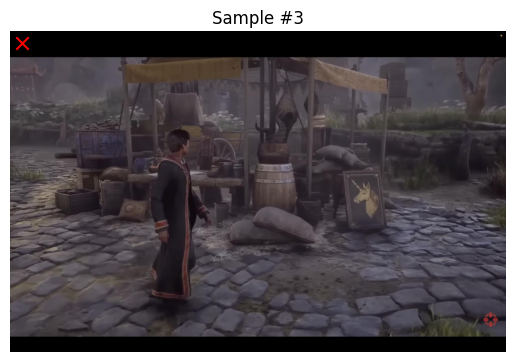

In [96]:
resized_images_path = "../datasets/resized_media/gameplay_images/hogwarts_legacy"
keypoints_file = resized_images_path + "/keypoints.csv"

# Define transforms
data_transforms = transforms.Compose([
    transforms.ToTensor()  # Convert PIL Image to tensor
])

def transform_sample(sample):
    image = data_transforms(sample['image'])
    landmarks = torch.tensor(sample['landmarks'], dtype=torch.float32)
    return {'image': image, 'landmarks': landmarks}

click_dataset = GameClickDataset(csv_file=keypoints_file,
                                    root_dir=resized_images_path,
                                    transform=transform_sample)
dataloader = DataLoader(click_dataset, batch_size=32, shuffle=True)


def show_landmarks(index, title=None):
    """Show image with landmarks"""
    image = click_dataset[index]['image']
    landmarks = click_dataset[index]['landmarks']
    title = f'Sample #{index}'

    image = image.permute(1, 2, 0)  # Transpose the image tensor
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=80, marker='x', c='r')
    plt.axis('off')  # Disable axes
    plt.title(title)

show_landmarks(index=3, title=None)

## From JSON file exported from human-label 

In [132]:
class GameClickDataset(Dataset):
    """Dataset for game click points from JSON."""

    def __init__(self, json_file, root_dir, transform=None):
        """
        Arguments:
            json_file (string): Path to the json file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(json_file) as f:
            self.data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        self.img_data= self.data[idx]['data']
        img_name = self.img_data['img'].split('?d=')[-1]
        image = io.imread(img_name)

        if 'kp-1' in self.img_data:
            landmarks = np.array([[kp['x'], kp['y']] for kp in self.data[idx]['kp-1']], dtype=float)
        else:
            landmarks = np.array([], dtype=float)

        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

tensor([])


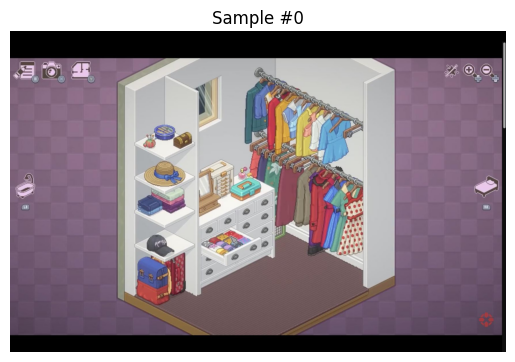

In [152]:
# resized_images_path = "../datasets/resized_media/gameplay_images"
json_file = resized_images_path + "/label_studio_tasks.json"

# Define transforms
data_transforms = transforms.Compose([
    transforms.ToTensor()  # Convert PIL Image to tensor
])

def transform_sample(sample):
    image = data_transforms(sample['image'])
    landmarks = torch.tensor(sample['landmarks'], dtype=torch.float32)
    return {'image': image, 'landmarks': landmarks}



click_dataset = GameClickDataset(json_file=json_file,
                                 root_dir=resized_images_path,
                                 transform=transform_sample)
dataloader = DataLoader(click_dataset, batch_size=32, shuffle=True)

def show_landmarks(index, title=None):
    """Show image with landmarks"""
    image = click_dataset[index]['image']
    landmarks = click_dataset[index]['landmarks']
    title = f'Sample #{index}'

    image = image.permute(1, 2, 0)  # Transpose the image tensor
    plt.imshow(image)
    print(landmarks)
    if landmarks.size(0) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=80, marker='x', c='r')
    plt.axis('off')  # Disable axes
    plt.title(title)

show_landmarks(index=0, title=None)